In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
import random

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('LoanStats3d.csv')

C:\Users\CISteele\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (1,20,56) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
categorical = df.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i + ': ' + str(column.nunique()))

id: 421097
term: 2
int_rate: 110
grade: 7
sub_grade: 35
emp_title: 120812
emp_length: 11
home_ownership: 4
verification_status: 3
issue_d: 12
loan_status: 7
pymnt_plan: 1
url: 421095
desc: 34
purpose: 14
title: 27
zip_code: 914
addr_state: 49
earliest_cr_line: 668
revol_util: 1211
initial_list_status: 2
last_pymnt_d: 25
next_pymnt_d: 4
last_credit_pull_d: 26
application_type: 2
verification_status_joint: 3


In [4]:
# Convert ID and Interest Rate to numeric.
df['id'] = pd.to_numeric(df['id'], errors='coerce')
df['int_rate'] = pd.to_numeric(df['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables (greater than 30)
df.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

# Drop columns with no predictive power (id numbers)
df.drop(['Unnamed: 0', 'id', 'member_id', ], 1, inplace=True)

# Remove two summary rows at the end that don't actually contain data.
df = df[:-2]

In [5]:
rfc = ensemble.RandomForestClassifier(n_estimators=10, max_depth = 10)
X = df.drop('loan_status', 1)
Y = df['loan_status']
X = pd.get_dummies(X, drop_first=True) # change categorical variables to dummy fields
X = X.dropna(axis=1)

In [6]:
# Normalize the data so that all variables have a mean of 0 and standard deviation of 1.
X_norm = StandardScaler().fit_transform(X)

# The NumPy covariance function assumes that variables are represented by rows, not columns, so we transpose X.
Xt = X_norm.T
Cx = np.cov(Xt)

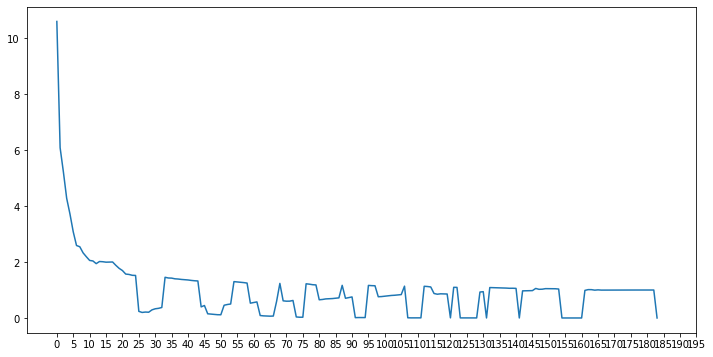

[ 1.06038134e+01  6.08884648e+00  5.22096812e+00  4.27903721e+00
  3.72052215e+00  3.08132895e+00  2.59176727e+00  2.54704994e+00
  2.32967757e+00  2.18914696e+00  2.05784323e+00  2.03923056e+00
  1.94338700e+00  2.01875763e+00  2.01168933e+00  1.99552236e+00
  1.99959947e+00  2.00206419e+00  1.88169540e+00  1.77430533e+00
  1.69643067e+00  1.57034122e+00  1.55674779e+00  1.52592350e+00
  1.52080319e+00  2.36508263e-01  1.97623265e-01  2.11874927e-01
  2.05542034e-01  2.89586887e-01  3.28649916e-01  3.44522543e-01
  3.74671940e-01  1.45512782e+00  1.42977028e+00  1.42540324e+00
  1.40077465e+00  1.39245302e+00  1.37806422e+00  1.36809486e+00
  1.35918361e+00  1.34285079e+00  1.33093995e+00  1.32349414e+00
  3.96846288e-01  4.45602506e-01  1.49525259e-01  1.39284673e-01
  1.27909829e-01  1.16689432e-01  1.14597504e-01  4.55276872e-01
  4.81846763e-01  4.99945412e-01  1.30004454e+00  1.28950462e+00
  1.27820850e+00  1.26507838e+00  1.24875932e+00  5.29388909e-01
  5.52551800e-01  5.74559

In [7]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Print scree plot
plt.figure(figsize = (12, 6))
plt.plot(eig_val_cov)
plt.xticks(np.arange(0, 200, 5))
plt.show()

print(eig_val_cov)

In the scree plot above, the decrease in error levels off at about 14 features.  Thus we will reduce dimensions to that number of fields using Principle Compnent Analysis.

In [8]:
# Reduce dimensions to 14 using PCA
pca = PCA(n_components=14)
pca_X_norm = pca.fit_transform(X_norm)

P = eig_vec_cov[:, 0]

# Transform X into Y.
Yt = P.T.dot(Xt)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.0579442  0.03327231 0.02852981 0.02338265 0.02033062 0.01683731
 0.01415869 0.01390645 0.01267673 0.01191751 0.01122845 0.01111534
 0.01100337 0.01095608]


In [9]:
X_pca = pd.DataFrame(pca_X_norm)

In [10]:
# Timing cross validation of the random forest classifier on reduced dataframe
start = time.time()
# Score the classifier on the standardized and reduced dataset
print(cross_val_score(rfc, X_pca, Y, cv=5))
end = time.time()
print(str(end - start) + ' seconds')

[0.91155203 0.92125292 0.92517128 0.93068073 0.90882105]
74.5807478427887 seconds


In [11]:
# Timing cross validation of the random forest classifier on original dataframe
start = time.time()
# Score the classifier on the unm,odified dataset
print(cross_val_score(rfc, X, Y, cv=5))
end = time.time()
print(str(end - start) + ' seconds')

[0.96999489 0.96452107 0.96649212 0.96551847 0.96548285]
56.871901512145996 seconds


In [12]:
rfc.fit(X_pca, Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [13]:
# Predict the status of a random entry in the standardized and reduced dataframe
record_index = random.randint(0, len(Y))
print('Index ' + str(record_index) + ' is ' + str(rfc.predict(X_pca[record_index:record_index+1])[0]) + ' with confidence ' + str(rfc.score(X_pca[record_index:record_index+1], Y[record_index:record_index+1])))

Index 192864 is Current with confidence 1.0


In [14]:
rfc.fit(X, Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
# Predict the status of a random entry in the original data
record_index = random.randint(0, len(Y))
print('Index ' + str(record_index) + ' is ' + str(rfc.predict(X[record_index:record_index+1])[0]) + ' with confidence ' + str(rfc.score(X[record_index:record_index+1], Y[record_index:record_index+1])))

Index 290762 is Fully Paid with confidence 1.0
